#BERTopic Modeling: Headlines in the US

Kate Campbell, Maddie Knappenberger, Takira Boltman

The data for this analysis was sourced from a Kaggle dataset, *Women in Headlines: Bias*. The original download was pre-processed in the Cleaning Headlines and Relationship Exploration notebooks. The data was further processed in this notebook to extract only headlines from the US, applying lemmatization and removing stopwords. 

We wanted to identify themes, or topics, within the headlines so we chose to use the BERTopic python library. "BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions." **[BERTopic](https://maartengr.github.io/BERTopic/index.html#bertopic.plotting._term_rank.visualize_term_rank)**

Additional libraries used:
* numpy
* UMAP
* sklearn
* nltk
* spacy
* seaborn
* matplotlib


###imports

In [ ]:
# Install bertopic (only do this once -- takes forever)
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 34.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

In [ ]:
import pandas as pd
import numpy as np

# topic model
from bertopic import BERTopic

# dimension reduction
from umap import UMAP
from sklearn.decomposition import PCA

# clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans

# text preprocessiong
import nltk
import spacy
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')
stopwords = nltk.corpus.stopwords.words('english')

# ploting
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# link to shared doc
url = 'https://drive.google.com/file/d/1OLDNamXmAh9xhFsXGEYEXCMZBAWZYMGM/view?usp=share_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

## Cleaning up Headlines

In [ ]:
headlines = df

In [ ]:
headlines

,Unnamed: 0,date,time,headline,site,country,bias,Polarity
0,9207,2016-02-03,08:00,Mother and Daughter Reunite After 82 Years,abcnews,USA,0.33,0.0000
1,9208,2016-01-19,08:00,Hayden Panettiere 'Happy' to Stand Up for Wome...,abcnews,USA,0.17,-0.5719
2,9209,2016-02-27,08:00,Woman Gets Trendy Tattoo to 'Caution' People S...,abcnews,USA,0.33,0.0000
3,9210,2016-02-03,08:00,Timeline of Alleged Abduction and Slaying of 1...,abcnews,USA,0.17,-0.5859
4,9211,2016-02-10,08:00,"Unabomber Ted Kaczynski's Brother, Sister in L...",abcnews,USA,0.17,0.0000
...,...,...,...,...,...,...,...,...
108250,354181,2021-05-05,07:00,Danielle Fishel Announces Her and Jensen Karp’...,usmagazine,USA,0.17,0.0000
108251,354182,2021-05-04,07:00,Pink Rewrote Her Will During ‘Scary’​​​​ COVID...,usmagazine,USA,0.17,-0.3818
108252,354183,2021-05-04,07:00,Joe Jonas Gushes Over His ‘Gorgeous’ Baby Girl...,usmagazine,USA,0.33,0.0000
108253,354184,2021-05-04,07:00,Chelsea Houska Left ‘Teen Mom 2’ for Daughter ...,usmagazine,USA,0.33,0.0000


In [ ]:
headlines = headlines[headlines['country'] == 'USA'].reset_index()

In [ ]:
headlines = headlines.drop(columns='Unnamed: 0')

In [ ]:
# remove stopwords
headlines['hl'] = headlines['headline'].apply(lambda sent: ' '.join([word for word in sent.split() if word.lower() not in nlp.Defaults.stop_words]))

In [ ]:
# lemmatization
headlines['hl'] = headlines['hl'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))

In [ ]:
headlines

,index,date,time,headline,site,country,bias,Polarity,hl
0,0,2016-02-03,08:00,Mother and Daughter Reunite After 82 Years,abcnews,USA,0.33,0.0000,Mother Daughter Reunite 82 Years
1,1,2016-01-19,08:00,Hayden Panettiere 'Happy' to Stand Up for Wome...,abcnews,USA,0.17,-0.5719,Hayden Panettiere 'Happy' Stand Women Postpart...
2,2,2016-02-27,08:00,Woman Gets Trendy Tattoo to 'Caution' People S...,abcnews,USA,0.33,0.0000,Woman Gets Trendy Tattoo 'Caution' People She'...
3,3,2016-02-03,08:00,Timeline of Alleged Abduction and Slaying of 1...,abcnews,USA,0.17,-0.5859,Timeline Alleged Abduction Slaying 13 Year Old...
4,4,2016-02-10,08:00,"Unabomber Ted Kaczynski's Brother, Sister in L...",abcnews,USA,0.17,0.0000,"Unabomber Ted Kaczynski's Brother, Sister Law ..."
...,...,...,...,...,...,...,...,...,...
53114,108250,2021-05-05,07:00,Danielle Fishel Announces Her and Jensen Karp’...,usmagazine,USA,0.17,0.0000,Danielle Fishel Announces Jensen Karp’s 2nd Pr...
53115,108251,2021-05-04,07:00,Pink Rewrote Her Will During ‘Scary’​​​​ COVID...,usmagazine,USA,0.17,-0.3818,Pink Rewrote ‘Scary’​​​​ COVID 19 Battle: ‘I T...
53116,108252,2021-05-04,07:00,Joe Jonas Gushes Over His ‘Gorgeous’ Baby Girl...,usmagazine,USA,0.33,0.0000,Joe Jonas Gushes ‘Gorgeous’ Baby Girl Willa 1s...
53117,108253,2021-05-04,07:00,Chelsea Houska Left ‘Teen Mom 2’ for Daughter ...,usmagazine,USA,0.33,0.0000,Chelsea Houska Left ‘Teen Mom 2’ Daughter Aubr...


##PCA to Identify Topics


In [ ]:
# use PCA for dimensionality reduction
pca = PCA(n_components=15)

# create BERTopic object
tm = BERTopic(umap_model=pca, language="english", calculate_probabilities=True)

# run BERTopic
topics = tm.fit_transform(headlines['hl'])

In [ ]:
results = tm.get_topic_info()
results

,Topic,Count,Name
0,-1,48455,-1_woman_women_girl_mother
1,0,4042,0_women_woman_new_girl
2,1,288,1_gaga_lady_gagas_kinney
3,2,74,2_pregnant_zika_women_vaccine
4,3,73,3_dies_mother_died_sister
5,4,50,4_missing_found_remains_woman
6,5,46,5_sexual_misconduct_accused_assault
7,6,40,6_mother_murder_death_mom
8,7,18,7_old_year_girl_dies
9,8,12,8_missing_mother_disappearance_search


In [ ]:
print(results['Count'].sum())

53119


Notice that there is a topic **-1**, this topic should be ignored as it indicates the headlines that could not be assigned to one of the topics. Unfortunately, in the process of reducing dimensionality, this PCA model left a significant portion of our headlines out of the topic sorting. We decided to try using the UMAP model with KMeans clustering to identify more topics within the headlines.

##UMAP model and KMeans Clustering to Identify Topics

In the UMAP model, the random state was assigned to ensure retestability, n_neighbors was set to the deafualt 15, the .n_components set the number of dimensions to 3, the min_dist was set to 0.0 to ensure clustering and the metric of measurement was set to cosine. With this model we control the number of topics found in the document by setting the n_clusters. We were looking for a varitey of topics so we chose to set parameters so that there would be 50 topics in the results. 

In [ ]:
# Initiate UMAP
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

In [ ]:
# Clustering model
kmeans = KMeans(n_clusters=50)

# Initiate BERTopic
tm = BERTopic(umap_model=umap_model, hdbscan_model=kmeans)

# Run BERTopic model
topics, probabilities = tm.fit_transform(headlines['hl'])

In [ ]:
tm.get_topic_info()

,Topic,Count,Name
0,0,3420,0_mother_murder_killed_old
1,1,2745,1_trump_obama_clinton_michelle
2,2,2084,2_woman_cop_police_video
3,3,1942,3_women_men_woman_female
4,4,1922,4_sister_mother_wives_death
5,5,1890,5_baby_pregnant_welcome_girl
6,6,1835,6_murder_man_woman_killing
7,7,1806,7_subway_brooklyn_woman_bronx
8,8,1787,8_missing_found_dead_body
9,9,1678,9_oprah_hollywood_review_movie


After running the new topic model, we can see a wider range in the topics found in the headlines. The topic names are a clunky, so we decided to generate new topic labels and limit the number of words to 2 most important words in the topic. 

In [ ]:
# create topic labels with better seperators 
topic_labels = tm.generate_topic_labels(nr_words=2, topic_prefix=False, separator=" ")

In [ ]:
# set custom labels
tm.set_topic_labels(topic_labels)

After processing we can see the extracted topics, frequency (count) of the topic usage in the document & custom labels we created:

In [ ]:
# Get the list of topics
info = tm.get_topic_info()
info

,Topic,Count,Name,CustomName
0,0,3420,0_mother_murder_killed_old,mother murder
1,1,2745,1_trump_obama_clinton_michelle,trump obama
2,2,2084,2_woman_cop_police_video,woman cop
3,3,1942,3_women_men_woman_female,women men
4,4,1922,4_sister_mother_wives_death,sister mother
5,5,1890,5_baby_pregnant_welcome_girl,baby pregnant
6,6,1835,6_murder_man_woman_killing,murder man
7,7,1806,7_subway_brooklyn_woman_bronx,subway brooklyn
8,8,1787,8_missing_found_dead_body,missing found
9,9,1678,9_oprah_hollywood_review_movie,oprah hollywood


Now that we've created the new labels that we can use in our visualizations later and verified that they represent the topics ineasily interpretable keywords we're ready to apply the topics to the headlines dataframe. Lets take a look at the first few rows of the headlines dataframe and see what it looks like now.

In [ ]:
# apply topics 
headlines['topic'] = tm.topics_[:]

In [ ]:
headlines[['headline', 'topic']].head(20)

,headline,topic
0,Mother and Daughter Reunite After 82 Years,27
1,Hayden Panettiere 'Happy' to Stand Up for Wome...,32
2,Woman Gets Trendy Tattoo to 'Caution' People S...,11
3,Timeline of Alleged Abduction and Slaying of 1...,8
4,"Unabomber Ted Kaczynski's Brother, Sister in L...",4
5,Debbie Wasserman Schultz Under Fire for Commen...,1
6,5 Year Old Girl Helps Blind Grandmother Escape...,20
7,Family Fighting to Allow Female World War II P...,37
8,Baby Girl Born on Same Day as Mother and Grand...,15
9,Woman Died of Dehydration While in Police Cust...,0


##Visualize the Topics

There are several built visualization tools in BERTopic that we will use to guide further exploration. 

One built in visualization shows the 2D representation of the topics witin the headlines. To use this visualization we took a sample of 10% of the headlines from each catergory and then mapped them on the headlines as 2D plane. The colors relate to the different topics and the density of represents where topics overlap in the headlines.

In [ ]:
tm.visualize_documents(headlines['hl'], sample=.1, hide_annotations=True, custom_labels=True)

Each topic is represented by a set of words assigned by the BERTopic algorithim. These words belong to the same topic but they do not necessarily equally represent the topic. In this bar chart the top 20 topics are broken down into individual words and ranked by their c-TF-IDF, or 'importance' scores. These scores indicate how representative of the topic a given word is within the topic. 



In [ ]:
tm.visualize_barchart(top_n_topics=20)

We can also use tools to see how topics are related to each other. We started by looking at the similarity matirx produced by the built in heatmap. This matrix is based of the cosine similarity matrix that is produced within the model to classify topics. Similarity scores range from 0 to 1 with 1 representing a higher similarity between the two topics.


In [ ]:
tm.visualize_heatmap(width=1000, custom_labels=True)

We can also see a hierarchical structure of the topic which is also determined by cosine similarity matrix that is produced within the model to classify topics. First we must create a hierarchy of the topics which is done with the builtin hierarchical_topics function. This function return the hierarchy of topics represented by their parents and their children and the distance between them. 

In [ ]:
hierarchical_topics = tm.hierarchical_topics(headlines['hl'])

100%|██████████| 49/49 [00:00<00:00, 109.43it/s]


In [ ]:
hierarchical_topics.head(2)

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
48,98,woman_girl_women_year_mother,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",80,woman_year_police_old_man,97,women_lady_girl_woman_new,1.775290
47,97,women_lady_girl_woman_new,"[1, 3, 4, 5, 9, 10, 11, 12, 14, 15, 16, 17, 18...",79,women_female_woman_trump_black,96,baby_girl_reveals_lady_says,1.350002


This simple visualization shows the hierarchy clustering of the topics. It isn't clear from the documenation what the different colors represent, but the brackets connect similar topics in a cascading fashion until one single bracket connects the entire hierarchy. 

In [ ]:
tm.visualize_hierarchy(custom_labels=True)

We can also look as a 2D visualization of the hierarchy of topics similarly to how we visualized the topics with the headlines above. We took a sample of 10% of the headlines from each catergory and then mapped them on the headlines as 2D plane. This visualization included a silder which highlights topics within the branches of hierarchy. 

In [ ]:
tm.visualize_hierarchical_documents(headlines['hl'], hierarchical_topics, sample=.1, hide_annotations=True, custom_labels=True)

The headlines are from 2005-2021, so we wondered how the frequency of the topics held over time. Fortunately, one of the built in functions of BERTtopic is the topics_over_time object which allows us to look at how topics changed over time including the frequency and common words asscocitated with the topic at that time. The topics over time object uses the date attribute from the previously preprocessed column 'date' to determine the frequency of the word at the given time. 

It was really difficult to distinguish trends in topic usage over time if all the topics were plotted so we decided to pull out a subset of the topics. After limiting the number of topics in the visualizer it's became really apparent that the frequency of the topics in the headlines varied over time. The visualizer also allows you to see the how the importance of words in the topic shift over time as well. 

In [ ]:
#create over_time object
topics_over_time = tm.topics_over_time(headlines['hl'], headlines['date'], nr_bins=20)

In [ ]:
tm.visualize_topics_over_time(topics_over_time, custom_labels=True, height=600, topics=[1, 5, 7, 10, 12, 14, 16])

##Topics and Polarity

Finally we wanted to explore whether there was any correlation between topics and polarity scores, but we found that for each topic the polarity score varied throughout the range. We concluded that this would not be a good metric for future study. Instead we decided to look at the average polarity scores and topics associated with each news source. 

We no longer need the modified headlines so we dropped that column, and reset dropped the extra index columns. Then we extract the site names from the headlines to create a new dataframe that holds the site, most commonly used topic and the average polarity score for the site. 

In [ ]:
# drop columns
headlines = headlines.drop(columns={'index', 'hl'})

# get unique headlines
sites = headlines['site'].unique()

# creat new df
by_site = pd.DataFrame()

# create empty column
by_site['topic name'] = "" 

In [ ]:
# for each site 
for s in range(len(sites)):
  # name the site
  by_site.loc[s, 'site'] = sites[s]

  # create a sub-dataframe
  ss = pd.DataFrame(headlines[headlines['site'] == sites[s]])

  # add the values 
  mode = ss['topic'].mode()[0]
  by_site.loc[s, 'most common topic'] = mode

  p = ss[ss['topic'] == mode]
  by_site.loc[s, 'polarity avg'] = p['Polarity'].mean().round(2)

In [ ]:
# line up the topic number with the topic name from info dataframe
for t in range(len(by_site)):
  for tn in range(len(info['Topic'])):
    if by_site.loc[t, 'most common topic'] == info.loc[tn, 'Topic']:
      by_site['topic name'].loc[t] = info.loc[tn, 'CustomName']

In [ ]:
#resulting dataframe
by_site

,site,most common topic,polarity avg,topic name
0,abcnews,0.0,-0.42,mother murder
1,cbsnews,0.0,-0.54,mother murder
2,eonline,12.0,0.14,kardashian kim
3,nbcnews,1.0,-0.00,trump obama
4,npr,1.0,0.02,trump obama
5,nydailynews,7.0,-0.45,subway brooklyn
6,nypost,7.0,-0.39,subway brooklyn
7,people,4.0,-0.04,sister mother
8,usatoday,10.0,0.10,team female
9,usmagazine,5.0,0.11,baby pregnant


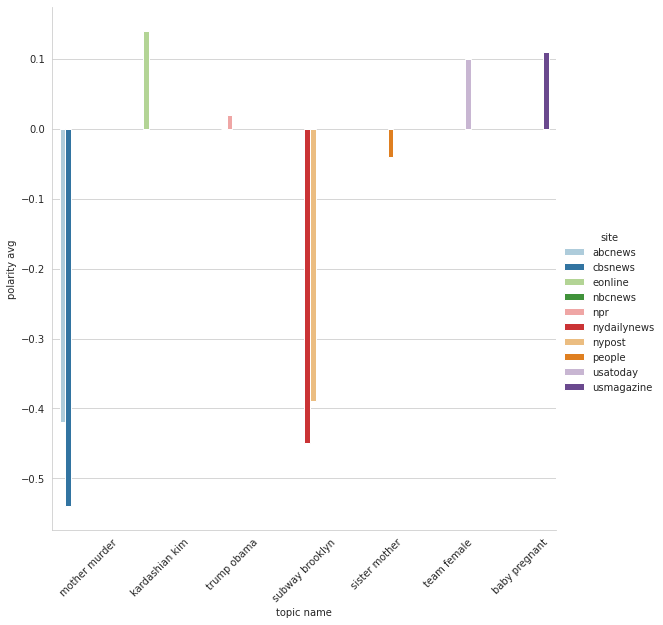

In [ ]:
sns.set_style("whitegrid")
sns.catplot(data=by_site, x='topic name', y='polarity avg', kind='bar', aspect= 1, height= 8, hue='site', palette = 'Paired')
plt.xticks(rotation=45)
plt.show()

As we can see, there is a very prevelant negative polarity score, or sentiment for half of the news sources and that polarity of the topic differed slightly depending on which new source was covering the topic. After looking at the plotted polarity we decided to go back to few of the visualizations to look a the different features of the most common topics.

In [ ]:
tm.visualize_barchart(topics=[0, 1, 4, 5, 7, 10, 12,])

In [ ]:
tm.visualize_topics_over_time(topics_over_time, custom_labels=True, height=600, topics=[0, 1, 4, 5, 7, 10, 12,])

#Conclusion

We used unsupervised learning to uncover hidden structures within our dataframe of headlines. Using the BERTopic model we were able to categorize the headlines into 50 topics. Each topic was comprised of a *bag of words* that were associated with the topic. The importance of the word to the topic varied over time and was measured in frequency of use.

After performing the topic modeling we explored some of the built in visualization tools looking for any structures in the data. We found that frequency of topic usage varied overtime as well as the importance of each word in the topic. 

Initially there was no obvious correlation between polarity and topics, so we sorted the headlines by news source, then determined there was a split in the distribution of the polarity scores. We plotted this relationship anf found that sites like abcnews, cbsnews, dailymailnews, nypost had high negative sentiment when evaluating it's most common topics.  